In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('poster')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

import statsmodels.formula.api as smf

In [250]:
columnDict = pd.read_csv('./columnDict.csv')
columnDict.replace({'2B':'doubles', '3B': 'triples'}, inplace=True)
columnDict.head()

,Column,Description
0,yearID,Year
1,lgID,League
2,teamID,Team
3,franchID,Franchise (links to TeamsFranchise table)
4,divID,Team's division


In [247]:
df = pd.read_csv('./baseball/core/Teams.csv')

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 48 columns):
yearID            2835 non-null int64
lgID              2785 non-null object
teamID            2835 non-null object
franchID          2835 non-null object
divID             1318 non-null object
Rank              2835 non-null int64
G                 2835 non-null int64
Ghome             2436 non-null float64
W                 2835 non-null int64
L                 2835 non-null int64
DivWin            1290 non-null object
WCWin             654 non-null object
LgWin             2807 non-null object
WSWin             2478 non-null object
R                 2835 non-null int64
AB                2835 non-null int64
H                 2835 non-null int64
2B                2835 non-null int64
3B                2835 non-null int64
HR                2835 non-null int64
BB                2835 non-null int64
SO                2715 non-null float64
SB                2691 non-null float64
CS    

In [249]:
df = df[df["yearID"]>=1977]
df.drop('Rank', axis=1, inplace=True)
df.fillna(0, inplace=True)

In [194]:
def winPer(w, l):
    return w/(w+l)
df['winP'] = df.apply(lambda row : winPer(row['W'], row['L']), axis=1)

In [215]:
df.rename(columns={'2B':'doubles', '3B': 'triples'}, inplace=True)

In [195]:
teams = df.teamID.unique()
validTeams = teams[df['teamID'].value_counts()>=40]

df = df[df['teamID'].isin(validTeams)]

In [196]:
quant = pd.DataFrame(df.loc[:, ~(df.dtypes == object)])
quant.drop(['L'], axis=1, inplace=True)


In [197]:
cols = quant.drop(['winP', 'W'], axis=1).columns
drop = ['SV', 'Rank', 'Wins', 'Losses', 'DivWin', 'WCWin', 'LgWin',
       'WSWin', 'HRA', 'HA', 'IPPouts', 'BPF', 'PPF', 'winP', 'W'
       'SHO', 'SO']
cols = [x for x in cols if x not in drop]

In [198]:
colsDrop = [x for x in cols if x not in ['W', 'yearID']]

In [199]:
wins = df.pivot_table(values='W',
                                index='yearID',
                                columns=['teamID'])

In [200]:
wins.head()

teamID,ATL,BAL,BOS,CAL,CHA,CHN,CIN,CLE,DET,HOU,...,ML4,MON,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN
yearID,,,,,,,,,,,,,,,,,,,,,
1977,61.0,97.0,97.0,74.0,90.0,81.0,88.0,71.0,74.0,81.0,...,67.0,75.0,100.0,64.0,63.0,101.0,96.0,69.0,64.0,75.0
1978,69.0,90.0,99.0,87.0,71.0,79.0,92.0,69.0,86.0,74.0,...,93.0,76.0,100.0,66.0,69.0,90.0,88.0,84.0,56.0,89.0
1979,66.0,102.0,91.0,88.0,73.0,80.0,90.0,81.0,85.0,89.0,...,95.0,95.0,89.0,63.0,54.0,84.0,98.0,68.0,67.0,71.0
1980,81.0,100.0,83.0,65.0,70.0,64.0,89.0,79.0,84.0,93.0,...,86.0,90.0,103.0,67.0,83.0,91.0,83.0,73.0,59.0,75.0
1981,50.0,59.0,59.0,51.0,54.0,38.0,66.0,52.0,60.0,61.0,...,62.0,60.0,59.0,41.0,64.0,59.0,46.0,41.0,44.0,56.0


In [201]:
wins.describe()

teamID,ATL,BAL,BOS,CAL,CHA,CHN,CIN,CLE,DET,HOU,...,ML4,MON,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN
count,40.000000,40.000000,40.000000,20.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,...,21.000000,28.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,82.725000,79.000000,85.725000,76.550000,80.17500,76.675000,79.400000,78.475000,78.050000,79.650000,...,78.714286,78.607143,89.650000,78.775000,80.550000,80.000000,75.875000,76.050000,74.600000,81.500000
std,15.065647,12.719861,10.278151,12.567607,10.03299,12.809026,9.507891,11.847292,13.944855,11.476956,...,11.958858,9.464707,11.310422,14.048428,13.763478,11.723306,13.401469,11.555773,13.552935,11.584694
min,50.000000,54.000000,54.000000,47.000000,54.00000,38.000000,61.000000,52.000000,43.000000,51.000000,...,53.000000,60.000000,59.000000,41.000000,51.000000,54.000000,46.000000,41.000000,44.000000,55.000000
25%,68.750000,68.750000,80.750000,70.750000,72.75000,69.500000,73.000000,69.750000,70.500000,74.000000,...,69.000000,70.250000,84.750000,68.750000,69.000000,70.750000,67.000000,69.750000,66.250000,74.250000
50%,87.000000,78.000000,87.000000,76.500000,80.00000,77.000000,78.000000,78.000000,82.000000,82.000000,...,80.000000,79.500000,90.500000,78.000000,77.500000,80.500000,75.000000,76.000000,75.500000,84.500000
75%,95.250000,89.000000,94.250000,87.250000,87.00000,84.250000,88.250000,86.750000,87.250000,86.000000,...,87.000000,85.250000,97.000000,89.250000,91.500000,89.000000,84.250000,83.250000,83.500000,90.000000
max,106.000000,102.000000,99.000000,93.000000,99.00000,103.000000,97.000000,100.000000,104.000000,102.000000,...,95.000000,95.000000,114.000000,108.000000,104.000000,102.000000,98.000000,98.000000,116.000000,103.000000


In [202]:
#Compute full-sample column-wise autocorrelation for a DataFrame.
def df_autocorr(df, lag=1, axis=0):
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

In [203]:
df_autocorr(wins)

teamID
ATL    0.559781
BAL    0.342180
BOS    0.100273
CAL    0.034747
CHA    0.086921
CHN    0.178788
CIN    0.251733
CLE    0.214439
DET    0.429657
HOU    0.384881
KCA    0.271418
LAN   -0.085439
MIN    0.434454
ML4    0.183527
MON    0.026593
NYA    0.470160
NYN    0.685782
OAK    0.582323
PHI    0.308677
PIT    0.466263
SDN    0.098791
SEA    0.281637
SFN    0.207755
dtype: float64

In [204]:
winP = df.pivot_table(values='winP',
                                index='yearID',
                                columns=['teamID'])

In [205]:
df_autocorr(winP)

teamID
ATL    0.765975
BAL    0.592913
BOS    0.050603
CAL   -0.119149
CHA    0.116619
CHN    0.180131
CIN    0.158303
CLE    0.387321
DET    0.472940
HOU    0.492789
KCA    0.543311
LAN   -0.103485
MIN    0.393882
ML4    0.284811
MON    0.325001
NYA    0.589740
NYN    0.664907
OAK    0.512113
PHI    0.537152
PIT    0.600899
SDN    0.038723
SEA    0.344479
SFN    0.272600
dtype: float64

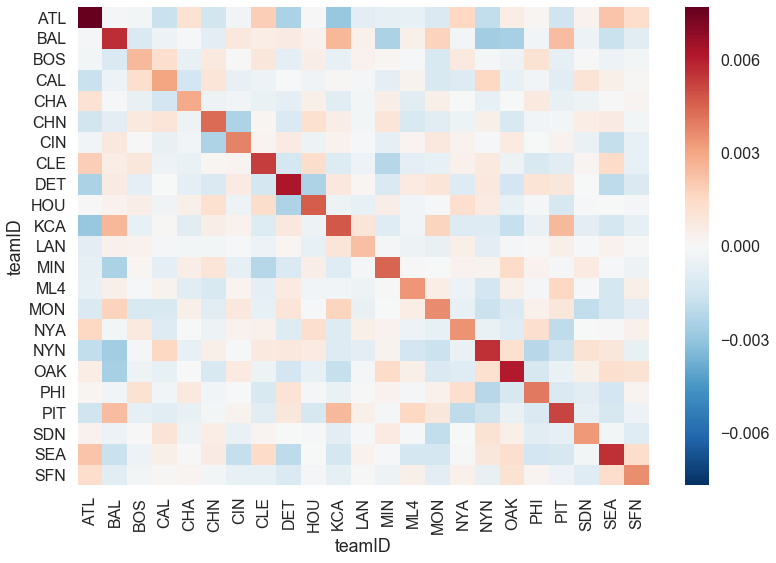

In [206]:
sns.heatmap(winP.cov())

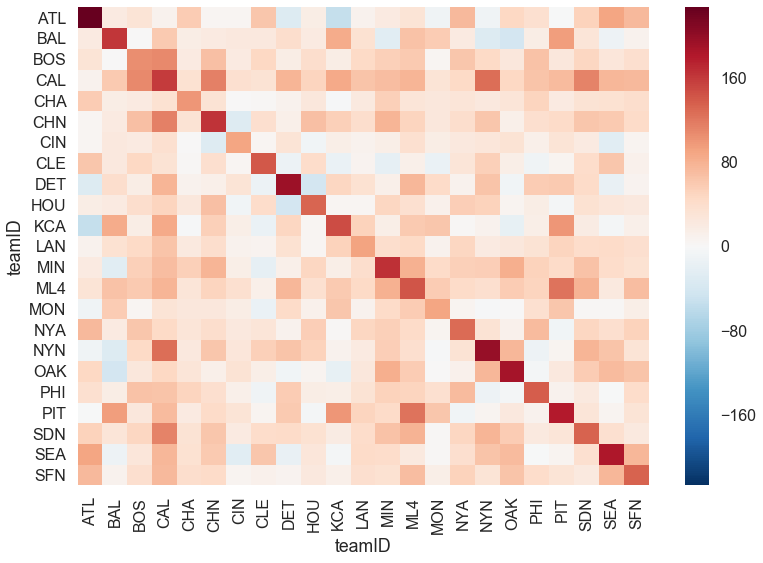

In [207]:
sns.heatmap(wins.cov())

In [208]:
corr = df.corr()
w, v = np.linalg.eig(corr)

In [209]:
w

array([  1.07795178e+01,   6.18360269e+00,   5.09505224e+00,
         2.60950139e+00,   1.83358738e+00,   1.26556000e+00,
         1.05925676e+00,   9.06500660e-01,   7.81490588e-01,
         6.36852696e-01,   5.57387209e-01,   4.92756299e-01,
         4.43405818e-01,   4.34327263e-01,   3.68407112e-01,
         3.51248762e-01,   2.55105071e-01,   1.94427830e-01,
         1.62402045e-01,   1.56747949e-01,   1.11556142e-01,
         7.39817038e-02,   6.68378441e-02,   5.34348837e-02,
         4.06792834e-02,   2.66500979e-02,   2.05389093e-02,
         1.04311726e-02,   1.45884249e-04,   1.21079716e-03,
         2.03275181e-03,   3.36853786e-03,   8.31416192e-03,
         6.72904655e-03,   6.95119247e-03])

In [272]:
vif = pd.DataFrame()

uncorrelated_cols = cols[np.abs(quant.corr()['W'])<.6]

vifQuants = quant[uncorrelated_cols].drop(['yearID'], axis=1)

vif["VIF Factor"] = [variance_inflation_factor(vifQuants.values, i) for i in range(vifQuants.shape[1])]
vif["features"] = vifQuants.columns
vif = vif.merge(columnDict, left_on='features', right_on='Column').drop('Column', axis=1)

vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features,Description
1,53072.981296,AB,At bats
25,27767.203335,BPF,Three-year park factor for batters
26,27602.579326,PPF,Three-year park factor for pitchers
0,23073.453615,G,Games played
13,13477.918149,ER,Earned runs allowed
23,8759.044348,FP,Fielding percentage
14,8564.200867,ERA,Earned run average
12,6336.473744,RA,Opponents runs scored
2,3376.070010,H,Hits by batters
17,2111.203770,HA,Hits allowed


In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=3000):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [278]:
result = calculate_vif_(vifQuants)

dropping 'AB' at index: 2
dropping 'BPF' at index: 26
dropping 'IPouts' at index: 17
dropping 'G' at index: 0
dropping 'ER' at index: 12
dropping 'RA' at index: 11
Remaining variables:
Index(['Ghome', 'H', 'doubles', 'triples', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP',
       'SF', 'ERA', 'CG', 'SHO', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'attendance', 'PPF'],
      dtype='object')


In [396]:
import time
import itertools

In [426]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    equation = "+".join(str(x) for x in list(feature_set))
    model = smf.ols('W~'+equation, data=quant).fit()
    mse = mean_squared_error(model.predict(quant[list(feature_set)]), quant['W'])
    return {"model":model, "R^2":model.rsquared, "Adj_R^2":model.rsquared_adj, "MSE": mse}

In [400]:
def getBest(k, X):
    tic = time.time()
    results = []
    for combo in itertools.combinations(quant.drop(['W', 'winP'],axis=1).columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    models.head()
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Adj_R^2'].argmin()]
    toc = time.time()
    
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [441]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in vifQuants.columns if p not in predictors]

    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [479]:
best_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])

tic = time.time()

for i in range(1,len(vifQuants)):
    models.loc[i] = getBest(i, X)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")

Processed  32 models on 1 predictors in 0.2579309940338135 seconds.
Total elapsed time: 0.2602391242980957 seconds.
Processed  496 models on 2 predictors in 5.476763010025024 seconds.
Total elapsed time: 5.739630937576294 seconds.


KeyboardInterrupt: 

In [ ]:
forward_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])
tic = time.time()
predictors = []
for i in range(1,len(vifQuants.columns)+1):
    forward_subset_models.loc[i] = forward(predictors)
    predictors = forward_subset_models.loc[i]["model"].model.exog_names
    
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")

Processed  29 models on 1 predictors in 0.2740297317504883 seconds.
Total elapsed time: 0.28194212913513184 seconds.
Processed  28 models on 3 predictors in 0.2717111110687256 seconds.
Total elapsed time: 0.5621240139007568 seconds.
Processed  27 models on 4 predictors in 0.3287699222564697 seconds.
Total elapsed time: 0.901313066482544 seconds.
Processed  26 models on 5 predictors in 0.41800713539123535 seconds.
Total elapsed time: 1.3240292072296143 seconds.
Processed  25 models on 6 predictors in 0.34136104583740234 seconds.
Total elapsed time: 1.670098066329956 seconds.
Processed  24 models on 7 predictors in 0.42846012115478516 seconds.
Total elapsed time: 2.10316801071167 seconds.
Processed  23 models on 8 predictors in 0.4024391174316406 seconds.
Total elapsed time: 2.5101120471954346 seconds.
Processed  22 models on 9 predictors in 0.42438793182373047 seconds.
Total elapsed time: 2.9385032653808594 seconds.
Processed  21 models on 10 predictors in 0.4387381076812744 seconds.
To

In [ ]:
forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]